# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



The goal of described model is to predict for bogo and discount types of offers if offer will be completed after it was viewed by customer using customer and offer information provided in dataset. In Features Engineering we explore offers and customer predictors to use in the model. As model RandomForest Classifier is used to classify if customer will complete offer. ROC Area Under the Curve is used for scoring as very suitable metrics for binary classification. As Model refinement the Light Gradient Boosting is used, it slightly improves results.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
#% matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import cross_validate
import lightgbm as lgb
import shap
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)


In [2]:
#functions

def modeling(model, X, Y):
    '''
    return and plot test and mean cross validation scores and plot features importance
    input: model, predictors dataframe, outcome
    output: test and mean cross validation scores and plot features importance 
    '''
    X_cross_val, X_test, y_cross_val, y_test = train_test_split(X, Y)
   # print(X_test[X_test["reward"].isna()])
    model.fit(X_cross_val, y_cross_val)
    y_pred=model.predict_proba(X_test)[:,1]
    y_pred_cv=model.predict_proba(X_cross_val)[:,1]
    score_test = roc_auc_score(y_test, y_pred)
    score_train = roc_auc_score(y_cross_val, y_pred_cv)
    #score_test_f1 = f1_score(y_test, y_pred)
    print("auc test score")
    print(score_test)
    plot_features(X_cross_val, model)
    
    score_validation = cross_validate(model, X_cross_val, y_cross_val, cv=3, scoring='recall')
    print("cross_validation")
    print(np.mean(score_validation["test_score"]))
    
    return score_train, score_test, score_validation, y_pred, y_test, X_test, model
    
    
def plot_features(X, model):
    '''
    plot random forest features importance
    input: dataframe X and regression model
    output: Feature importance plot
    '''
    print("Plot feature importances…")
    headers = ["name", "score"]
    values = sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1] * -1)
    forest_feature_importances = pd.DataFrame(values, columns = headers)
    forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)
    features = forest_feature_importances['name'][:25]
    y_pos = np.arange(len(features))
    scores = forest_feature_importances['score'][:25]
    #plot feature importances
    plt.figure(figsize=(10,5))
    plt.bar(y_pos, scores, align='center', alpha=0.5)
    plt.xticks(y_pos, features, rotation='vertical')
    plt.ylabel('Score')
    plt.xlabel('Features')
    plt.title('Feature importances ')
    plt.show()

## Portfolio dataset

Dataset includes features which describe offer. Here we also separate channels: wed, social, mobile, email to separate columns and check which was used, and count how many channels total are used for each offer.

In [3]:
print(portfolio.head())
print("Types of offer:")
channels=["web", "email", "mobile", "social"]
portfolio["num_channels"]=   portfolio["channels"].apply(lambda x: len(x))
#put channels to one string
portfolio['channels']=portfolio['channels'].apply(lambda x: "".join(x))
for i in channels: 
    portfolio[i] = 0
    #check if string contains channel
    portfolio.loc[portfolio['channels'].str.contains(i), [i]] = 1
portfolio = portfolio.drop("channels", axis=1)
portfolio.head

   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
Types of offer:


<bound method NDFrame.head of    reward  difficulty  duration     offer_type  \
0      10          10         7           bogo   
1      10          10         5           bogo   
2       0           0         4  informational   
3       5           5         7           bogo   
4       5          20        10       discount   
5       3           7         7       discount   
6       2          10        10       discount   
7       0           0         3  informational   
8       5           5         5           bogo   
9       2          10         7       discount   

                                 id  num_channels  web  email  mobile  social  
0  ae264e3637204a6fb9bb56bc8210ddfd             3    0      1       1       1  
1  4d5c57ea9a6940dd891ad53e9dbe8da0             4    1      1       1       1  
2  3f207df678b143eea3cee63160fa8bed             3    1      1       1       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9             3    1      1       1       0  
4  0b1e1539f2cc45b7

### Types of offers

There are 3 types of offers 

['bogo' 'informational' 'discount']


(array([4., 0., 0., 0., 0., 2., 0., 0., 0., 4.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

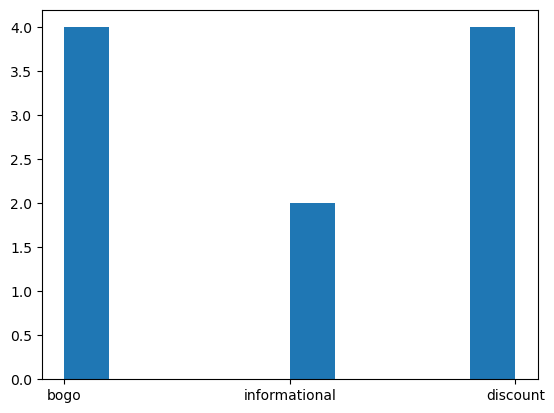

In [4]:
print(portfolio.offer_type.unique())
plt.hist(portfolio['offer_type'])

### Difficulty score

[10  0  5 20  7]


(array([2., 0., 2., 1., 0., 4., 0., 0., 0., 1.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

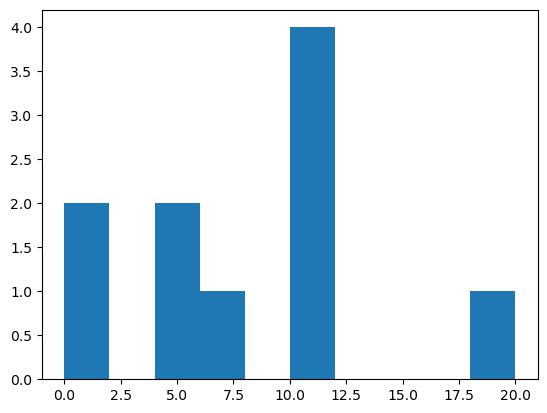

In [5]:
print(portfolio.difficulty.unique())
plt.hist(portfolio['difficulty'])

### Rewards 

[10  0  5  3  2]


(array([2., 0., 2., 1., 0., 3., 0., 0., 0., 2.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

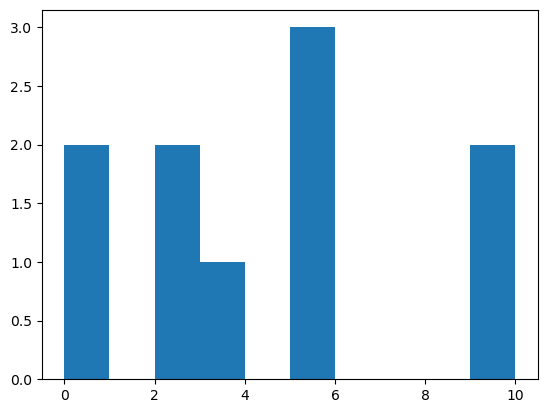

In [6]:
print(portfolio.reward.unique())
plt.hist(portfolio['reward'])

One can see that rewards correspond to difficulty

## Profile

In [7]:
profile=profile.rename(columns={"id": "person"})
#fill income na with mean score
mean_income = profile["income"].mean()
profile['income'] = profile['income'].fillna(mean_income)
print(profile.head())

  gender  age                            person  became_member_on  \
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212   
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715   
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712   
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509   
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804   

          income  
0   65404.991568  
1  112000.000000  
2   65404.991568  
3  100000.000000  
4   65404.991568  


In [8]:
profile["gender"]=profile["gender"].fillna("unknown")

In [9]:
profile["gender"].unique()

array(['unknown', 'F', 'M', 'O'], dtype=object)

(array([2175.,    0.,    0., 6129.,    0.,    0., 8484.,    0.,    0.,
         212.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

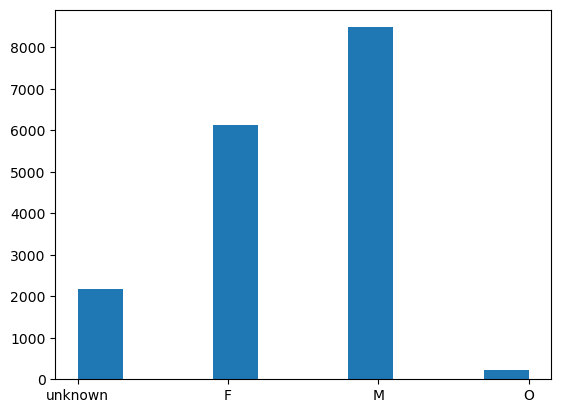

In [10]:

plt.hist(profile['gender'])

## Transcript preprocessing

In [11]:
print(transcript.head())
print(transcript.event.unique())

                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
['offer received' 'offer viewed' 'transaction' 'offer completed']


We do not know right away which order is completed. 

In [12]:
print(transcript[transcript['event']=="offer completed"].head())

                                 person            event  \
12658  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  offer completed   
12672  fe97aa22dd3e48c8b143116a8403dd52  offer completed   
12679  629fc02d56414d91bca360decdfa9288  offer completed   
12692  676506bad68e4161b9bbaffeb039626b  offer completed   
12697  8f7dd3b2afe14c078eb4f6e6fe4ba97d  offer completed   

                                                   value  time  
12658  {'offer_id': '2906b810c7d4411798c6938adc9daaa5...     0  
12672  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...     0  
12679  {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...     0  
12692  {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...     0  
12697  {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...     0  


First we need to extract event from dictionary.

In [13]:
transcript['value']=transcript.value.apply(lambda x: x.get("offer id"))
print(transcript.event.unique())
transcript.head()

['offer received' 'offer viewed' 'transaction' 'offer completed']


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [14]:
print(transcript[transcript['event']=="offer completed"].head())

                                 person            event value  time
12658  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  offer completed  None     0
12672  fe97aa22dd3e48c8b143116a8403dd52  offer completed  None     0
12679  629fc02d56414d91bca360decdfa9288  offer completed  None     0
12692  676506bad68e4161b9bbaffeb039626b  offer completed  None     0
12697  8f7dd3b2afe14c078eb4f6e6fe4ba97d  offer completed  None     0


From table above we still do not know which offer is completed, value = None. To find out we need we need to sort out events by time for each customer. For Bogo and discount events offer completed follows transaction right away. We need also exclude events when offer was comleted by chance before it was viewed.

In [15]:
transcript = transcript.rename(columns={'value': 'id'})
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

We need to sort events in time for each person to find out which "offer viewed" is followed by "tansaction" and offfer completed"

In [16]:
transcript = transcript.sort_values(['person','time'])
transcript = transcript.fillna(method='ffill')
transcript

,person,event,id,time
55972,0009655768c64bdeb2e877511632db8f,offer received,5a8bc65990b245e5a138643cd4eb9837,168
77705,0009655768c64bdeb2e877511632db8f,offer viewed,5a8bc65990b245e5a138643cd4eb9837,192
89291,0009655768c64bdeb2e877511632db8f,transaction,5a8bc65990b245e5a138643cd4eb9837,228
113605,0009655768c64bdeb2e877511632db8f,offer received,3f207df678b143eea3cee63160fa8bed,336
139992,0009655768c64bdeb2e877511632db8f,offer viewed,3f207df678b143eea3cee63160fa8bed,372
...,...,...,...,...
258361,ffff82501cea40309d5fdd7edcca4a07,transaction,2906b810c7d4411798c6938adc9daaa5,576
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,2906b810c7d4411798c6938adc9daaa5,576
262475,ffff82501cea40309d5fdd7edcca4a07,offer viewed,2906b810c7d4411798c6938adc9daaa5,582
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,2906b810c7d4411798c6938adc9daaa5,606


## Put all together

In [17]:
##To check that only bogo and discount events have offer completed.

df=pd.merge(portfolio, transcript, on = "id", how="left")
print(len(df.loc[df['event']=='offer completed'][df['offer_type']=='bogo']))
print(len(df.loc[df['event']=='offer completed'][df['offer_type']=='infomational']))
print(len(df.loc[df['event']=='offer completed'][df['offer_type']=='discount']))
##Bogo and discount offer and offer viewed and completed events are filtered out
df=df.loc[df['offer_type'].isin(['bogo', 'discount'])&(df['event'].isin(["offer viewed", "offer completed"]))]
df=df.drop_duplicates(subset=["id", "person", "event"])
df_count = df[["id", "person", "event"]].groupby(["id", "person"]).count().rename(columns= {'event': 'event_count'}).reset_index()
df=pd.merge(df, df_count, on=["id", 'person'], how='left')
## 1 is for events that were viewed before
df['event_count']=df["event_count"].replace(1,0)
df['event_count']=df["event_count"].replace(2,1)
df.head()

16180
0
16367


,reward,difficulty,duration,offer_type,id,num_channels,web,email,mobile,social,person,event,time,event_count
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,004c5799adbf42868b9cff0396190900,offer completed,336,0
1,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,005500a7188546ff8a767329a2f7c76a,offer viewed,60,1
2,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,005500a7188546ff8a767329a2f7c76a,offer completed,582,1
3,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,0063def0f9c14bc4805322a488839b32,offer viewed,186,0
4,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,00715b6e55c3431cb56ff7307eb19675,offer completed,12,1


Bogo and discount offers have event order completed. I will predict for these types if order is completed.

In [18]:
#exclude events where offer is completed by chance
df=df.loc[~((df['event']=="offer completed")&(df['event_count']==0))]
df=pd.merge(df, profile, on="person", how="left")
print(df.reward.unique())
print(df.duration.unique())
df=df.drop(['event'], axis=1)
#convert became_member_on into days
df['year']=df['became_member_on'].apply(lambda x: int(str(x)[:4]))
df['month']=df['became_member_on'].apply(lambda x: int(str(x)[4:6]) if str(x)[4]=='1' else int(str(x)[-3:-2]))
df['day']=df['became_member_on'].apply(lambda x: int(str(x)[-2:]))
df = df.drop('became_member_on', axis=1, inplace=False)
df.loc[df['year'] == 2018, 'membership_len'] = (30*df['month'].astype('float'))+df['day']
df.loc[df['year'] != 2018, 'membership_len'] = ((2018-df['year'].astype('int'))*365)+(30*df['month'].astype('float'))+df['day']
df = df.drop(['year','month','day'], axis=1, inplace=False)
df.head()

[10  5  3  2]
[ 7  5 10]


,reward,difficulty,duration,offer_type,id,num_channels,web,email,mobile,social,person,time,event_count,gender,age,income,membership_len
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,005500a7188546ff8a767329a2f7c76a,60,1,M,56,47000.000000,734.0
1,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,005500a7188546ff8a767329a2f7c76a,582,1,M,56,47000.000000,734.0
2,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,0063def0f9c14bc4805322a488839b32,186,0,unknown,118,65404.991568,195.0
3,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,00715b6e55c3431cb56ff7307eb19675,12,1,F,58,119000.000000,732.0
4,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,00715b6e55c3431cb56ff7307eb19675,36,1,F,58,119000.000000,732.0


We assign 1 if offer were completed and 0 if it is not. 

(array([17462.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 22364.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

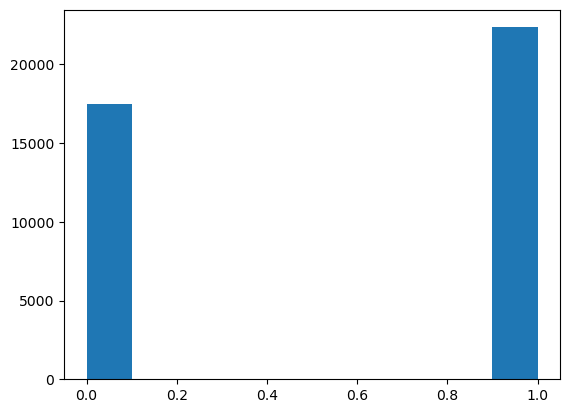

In [19]:
df=df.drop_duplicates(subset =['id', 'person', 'event_count'], keep='first')
plt.hist(df['event_count'])

The outcome is slightly imbalanced. More viewed offers are completed than not completed. 

## Model

In [20]:
# numeric columns
num_col=['membership_len', "age", 'income']#
#categorical columns
cat_col = [i for i in df.columns if i not in num_col+['id', "difficulty", 'person','web', 'email', "offer_type", 'time', 'mobile','social', 'event_count', "num_channels", 'duration', 'membership_len']]
add_col = ['web', "offer_type",'email', 'mobile','social',  "num_channels", "difficulty"]

print(cat_col)

['reward', 'gender']


In [21]:
df=df.dropna(how="all",  subset=num_col+cat_col)
df

,reward,difficulty,duration,offer_type,id,num_channels,web,email,mobile,social,person,time,event_count,gender,age,income,membership_len
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,005500a7188546ff8a767329a2f7c76a,60,1,M,56,47000.000000,734.0
2,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,0063def0f9c14bc4805322a488839b32,186,0,unknown,118,65404.991568,195.0
3,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,00715b6e55c3431cb56ff7307eb19675,12,1,F,58,119000.000000,732.0
5,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,00857b24b13f4fe0ad17b605f00357f5,522,0,M,71,41000.000000,688.0
6,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,3,0,1,1,1,008d7088107b468893889da0ede0df5c,408,0,M,24,42000.000000,645.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62182,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,3,1,1,1,0,ff40374e1ece425ea5ced2a3531bbe1c,594,1,M,69,70000.000000,99.0
62184,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,3,1,1,1,0,ffd810f301ad42d6bfe98c4ba6ee4125,492,0,M,65,52000.000000,75.0
62185,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,3,1,1,1,0,ffeaa02452ef451082a0361c3ca62ef5,48,1,F,67,77000.000000,444.0
62187,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,3,1,1,1,0,ffecb1f8543f4bf7bade023de366d6bf,174,0,unknown,118,65404.991568,692.0


### RandomForestClassifier

['membership_len', 'age', 'income', 'reward', 'gender']
auc test score
0.7625659805893074
Plot feature importances…


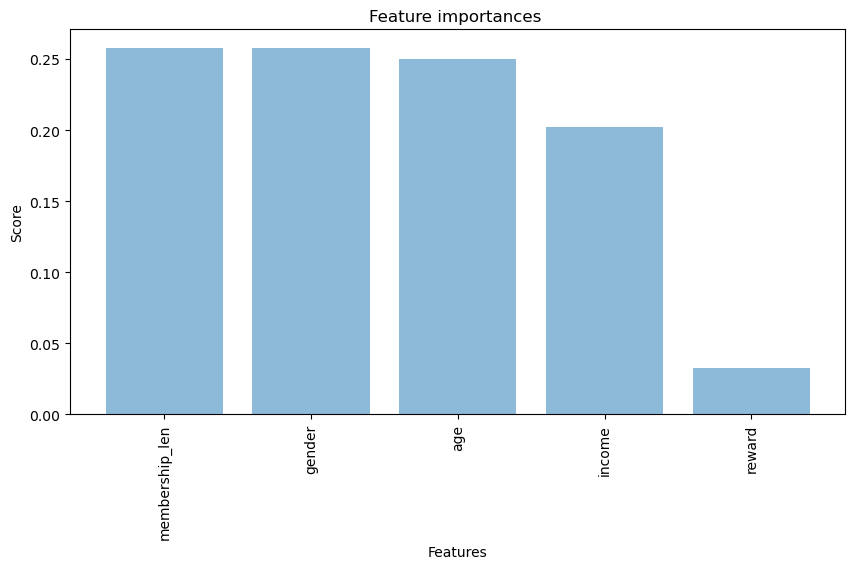

cross_validation
0.807367782278822


In [22]:
#incoding of categorical columns
le  = LabelEncoder()
print(num_col+cat_col)
#df=df[~df["gender"].isna()]
X=df[num_col+cat_col]
#X['gender']=X['gender'].fillna("Unknown")
for i in cat_col:
    X[i]=le.fit_transform(X[i].astype('category'))
Y=df['event_count']
model = RandomForestClassifier(max_depth = 3, class_weight="balanced")
score_train, score_test, score_validation, y_pred, y_test, X_test, model=modeling(model, X, Y)

In [23]:
score_train

0.7712210672671649

In [24]:
df[add_col]

,web,offer_type,email,mobile,social,num_channels,difficulty
0,0,bogo,1,1,1,3,10
2,0,bogo,1,1,1,3,10
3,0,bogo,1,1,1,3,10
5,0,bogo,1,1,1,3,10
6,0,bogo,1,1,1,3,10
...,...,...,...,...,...,...,...
62182,1,discount,1,1,0,3,10
62184,1,discount,1,1,0,3,10
62185,1,discount,1,1,0,3,10
62187,1,discount,1,1,0,3,10


###### Most contributed feature is age. AUC score is 0.77.

### Model improvements, Light Gradient Boosting

Light gradient boosting has better result on cross validation, auc score is 0.8 and on test set auc score is also 0.8

['membership_len', 'age', 'income', 'reward', 'gender']
auc test score
0.7673715448193784
Plot feature importances…


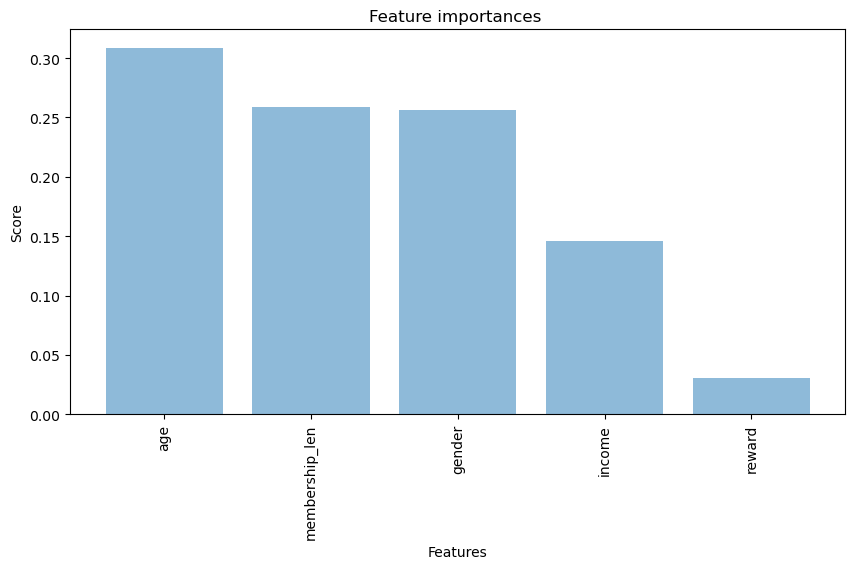

cross_validation
0.8092884577037226


In [25]:
model = lgb.LGBMClassifier(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=31, max_depth = 3, class_weight="balanced", random_seed=2)
#incoding of categorical columns
le  = LabelEncoder()
print(num_col+cat_col)
#df=df[~df["gender"].isna()]
X=df[num_col+cat_col]
#X['gender']=X['gender'].fillna("Unknown")
for i in cat_col:
    X[i]=le.fit_transform(X[i].astype('category'))
Y=df['event_count']
model = RandomForestClassifier(max_depth = 3, class_weight="balanced")
score_train, score_test, score_validation, y_pred, y_test, X_test, model=modeling(model, X, Y)

In [26]:
results0=pd.DataFrame()

In [27]:
results0["pred"]=y_pred

In [28]:
results0["test"]=list(y_test)

In [29]:
results0

,pred,test
0,0.717929,1
1,0.713637,0
2,0.621833,0
3,0.472698,1
4,0.549123,1
...,...,...
9952,0.717393,1
9953,0.684432,0
9954,0.651330,1
9955,0.422988,1


## SHAP feature importance

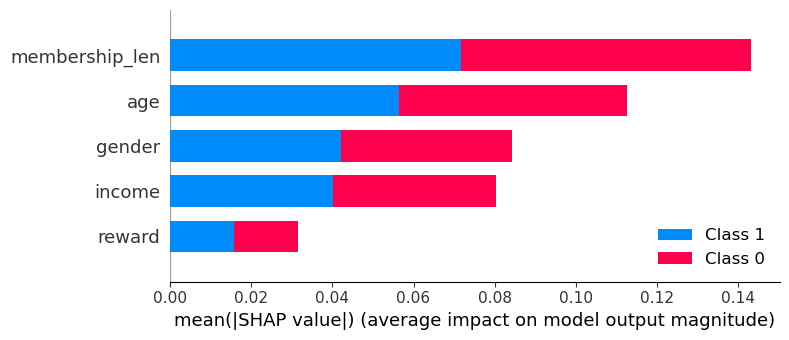

In [30]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type="bar")

## What features combinations are related to wrong pedictions

## False positives

In [31]:
results=pd.concat([results0, X_test[num_col+cat_col].reset_index()], axis=1)
results

,pred,test,index,membership_len,age,income,reward,gender
0,0.717929,1,39503,1475.0,59,118000.000000,0,0
1,0.713637,0,53310,1381.0,57,90000.000000,2,0
2,0.621833,0,42019,652.0,39,70000.000000,0,1
3,0.472698,1,22848,236.0,77,74000.000000,2,0
4,0.549123,1,20172,511.0,78,43000.000000,2,1
...,...,...,...,...,...,...,...,...
9952,0.717393,1,40866,1050.0,77,112000.000000,0,0
9953,0.684432,0,55297,1395.0,48,97000.000000,2,1
9954,0.651330,1,39546,674.0,52,99000.000000,0,1
9955,0.422988,1,62080,171.0,46,54000.000000,0,0


In [32]:
test_error=results[(results["pred"]>0.7)&(results["test"]==0)]
test_error#.dropna()

,pred,test,index,membership_len,age,income,reward,gender
1,0.713637,0,53310,1381.0,57,90000.0,2,0
93,0.711871,0,30369,804.0,65,75000.0,1,0
108,0.715055,0,50107,1015.0,56,108000.0,2,0
241,0.715391,0,44861,869.0,52,86000.0,0,0
329,0.701640,0,3913,1424.0,52,85000.0,3,0
...,...,...,...,...,...,...,...,...
9343,0.717393,0,60392,1371.0,65,103000.0,0,0
9429,0.700911,0,15940,851.0,44,81000.0,3,0
9534,0.714222,0,19150,942.0,71,81000.0,2,0
9609,0.715975,0,36455,1393.0,64,85000.0,1,0


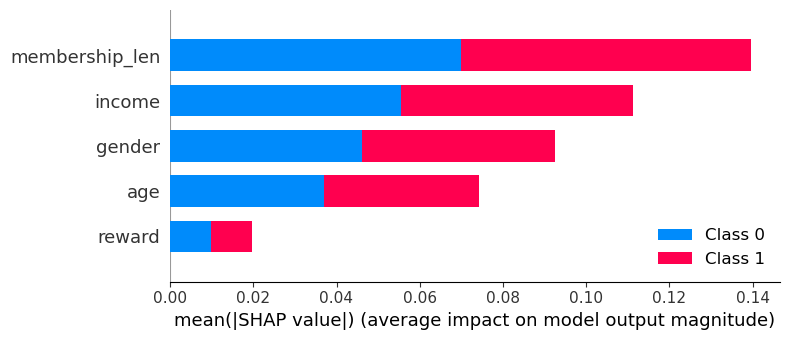

In [33]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(test_error.reset_index()[X.columns])
shap.summary_plot(shap_values, features=test_error.reset_index()[X.columns], feature_names=X.columns, plot_type="bar")

In [34]:
#shap_values = explainer.shap_values(X)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], test_error.reset_index()[X.columns], feature_names=X.columns, link="logit")

## False negative

In [35]:
test_error=results[(results["pred"]<0.2)&(results["test"]==1)]
#test_error=test_error.dropna()

In [36]:
test_error

,pred,test,index,membership_len,age,income,reward,gender
26,0.089125,1,61997,42.0,118,65404.991568,0,3
125,0.174453,1,49997,1375.0,118,65404.991568,2,3
186,0.175883,1,18164,949.0,118,65404.991568,2,3
285,0.076978,1,50572,149.0,118,65404.991568,2,3
289,0.143600,1,51646,732.0,118,65404.991568,2,3
...,...,...,...,...,...,...,...,...
9604,0.183992,1,45482,1391.0,118,65404.991568,0,3
9676,0.185423,1,61554,966.0,118,65404.991568,0,3
9734,0.174453,1,54411,1430.0,118,65404.991568,2,3
9787,0.143600,1,52828,605.0,118,65404.991568,2,3


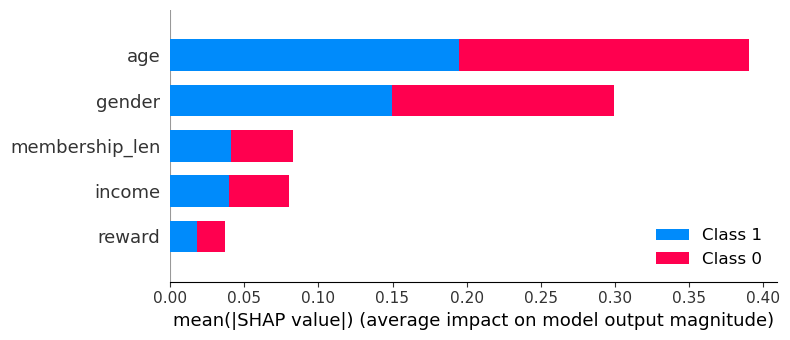

In [37]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(test_error.reset_index()[X.columns])
shap.summary_plot(shap_values, features=test_error.reset_index()[X.columns], feature_names=X.columns, plot_type="bar")

In [38]:
#shap_values = explainer.shap_values(X)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], test_error.reset_index()[X.columns], feature_names=X.columns,link="logit")

## Income distribution

In [39]:
shap_values = explainer.shap_values(X)

In [40]:
def model_proba(x):
    return model.predict_proba(x)[:, 1]

(array([ 3752.,  3578.,  5270., 10693.,  5523.,  3486.,  3049.,  2420.,
         1078.,   977.]),
 array([ 30000.,  39000.,  48000.,  57000.,  66000.,  75000.,  84000.,
         93000., 102000., 111000., 120000.]),
 <BarContainer object of 10 artists>)

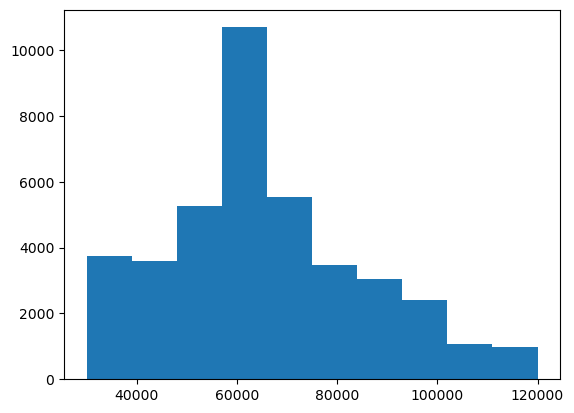

In [41]:
plt.hist(X["income"])

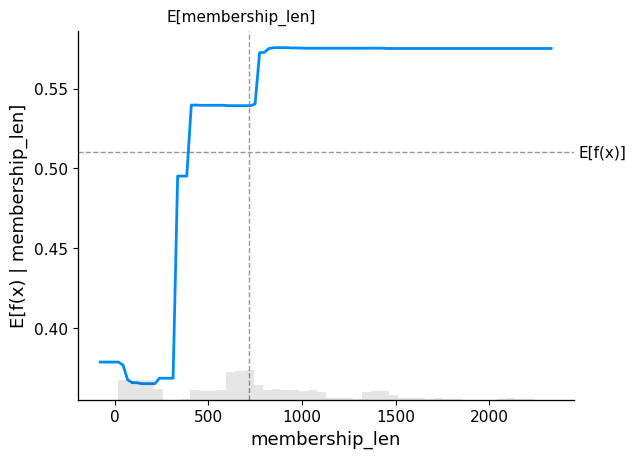

In [42]:
fig, ax = shap.partial_dependence_plot(
    "membership_len",
    model_proba,
    X,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    
  #  shap_values=shap_values[10: 10 + 1, :],
)

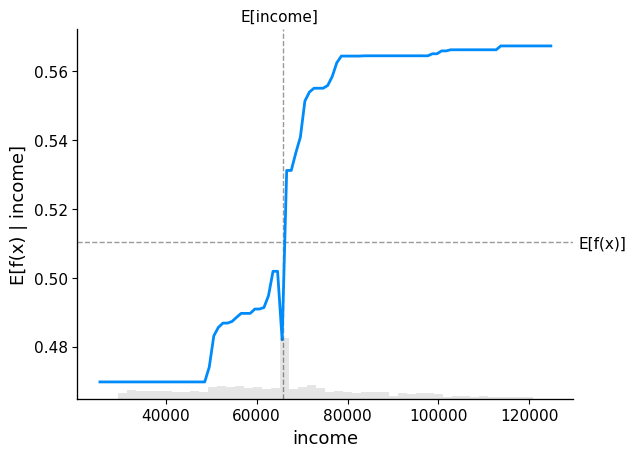

In [43]:
fig, ax = shap.partial_dependence_plot(
    "income",
    model_proba,
    X,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False, 
  #  shap_values=shap_values[10: 10 + 1, :],
)

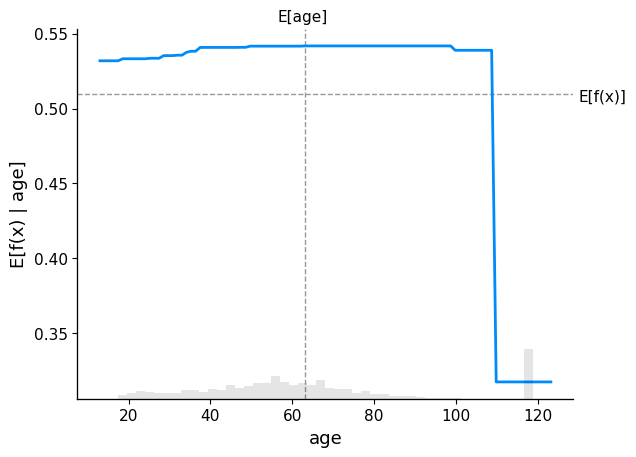

In [44]:
fig, ax = shap.partial_dependence_plot(
    "age",
    model_proba,
    X_test,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    
  #  shap_values=shap_values[10: 10 + 1, :],
)

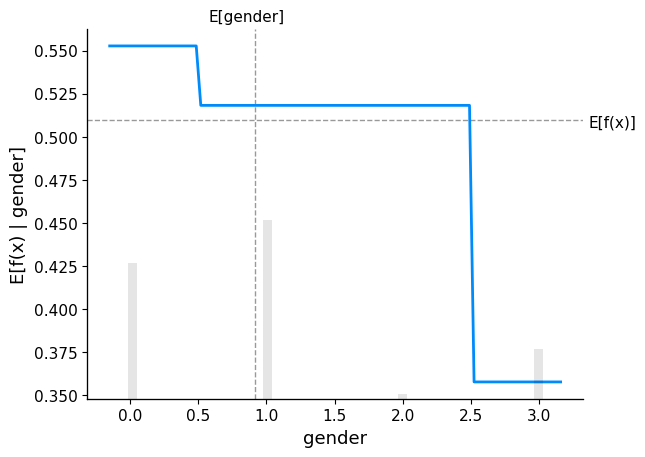

In [45]:
fig, ax = shap.partial_dependence_plot(
    "gender",
    model_proba,
    X_test,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    
  #  shap_values=shap_values[10: 10 + 1, :],
)

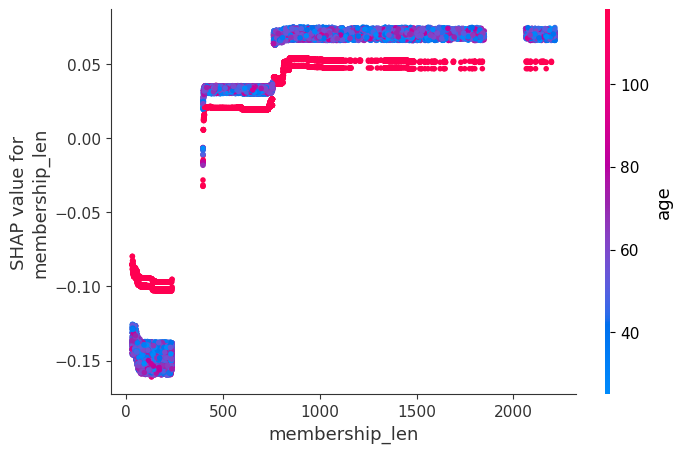

In [47]:
shap.dependence_plot(0, shap_values[1], X, interaction_index=1)

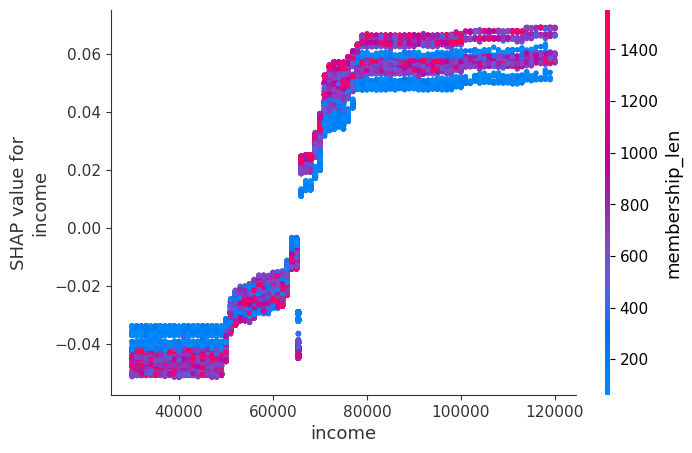

In [49]:
shap.dependence_plot(2, shap_values[1], X, interaction_index=0)

## Membership length distribution

(array([9858., 1611., 8793., 8097., 4903., 1139., 3467.,  991.,  296.,
         671.]),
 array([  31. ,  249.5,  468. ,  686.5,  905. , 1123.5, 1342. , 1560.5,
        1779. , 1997.5, 2216. ]),
 <BarContainer object of 10 artists>)

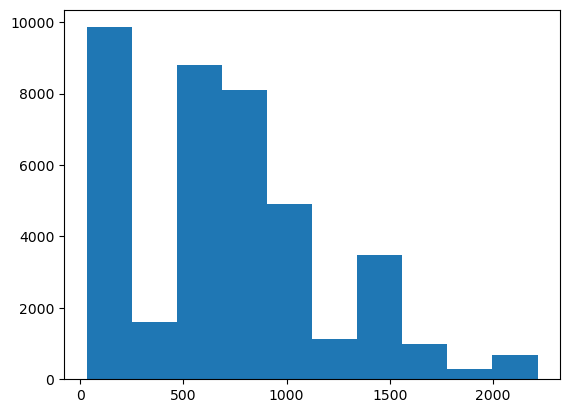

In [50]:
plt.hist(X["membership_len"])

### True positives

In [51]:
test_rightposit=results[(results["pred"]>0.7)&(results["test"]==1)]
test_rightposit

,pred,test,index,membership_len,age,income,reward,gender
0,0.717929,1,39503,1475.0,59,118000.0,0,0
52,0.713637,1,56277,961.0,60,94000.0,2,0
63,0.716809,1,46717,992.0,50,106000.0,0,0
72,0.702225,1,3812,953.0,72,90000.0,3,0
123,0.714222,1,24882,901.0,75,83000.0,2,0
...,...,...,...,...,...,...,...,...
9902,0.702225,1,15802,976.0,78,85000.0,3,0
9905,0.703643,1,13615,1467.0,67,111000.0,3,0
9923,0.717393,1,40655,1415.0,68,101000.0,0,0
9951,0.701640,1,8454,927.0,62,81000.0,3,0


In [52]:
np.max(results["pred"])

0.7185138387815938

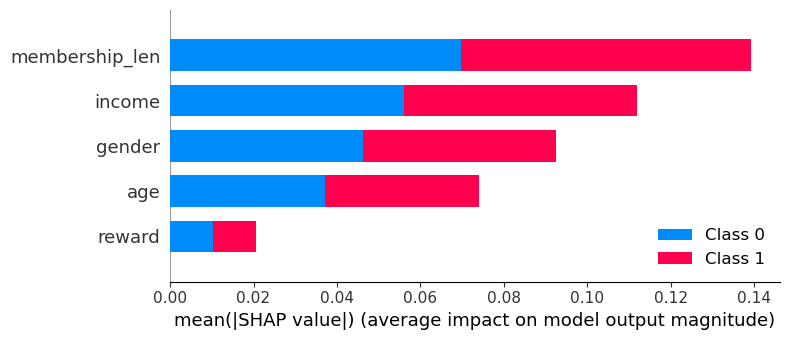

In [53]:
shap_values = explainer.shap_values(test_rightposit.reset_index()[X.columns])
shap.summary_plot(shap_values, features=test_rightposit.reset_index()[X.columns], feature_names=X.columns, plot_type="bar")

In [54]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], test_rightposit.reset_index()[X.columns], feature_names=X.columns, link="logit")

### True negative

In [55]:
test_trueneg=results[(results["pred"]<0.2)&(results["test"]==0)]
#test_error=test_error.dropna()

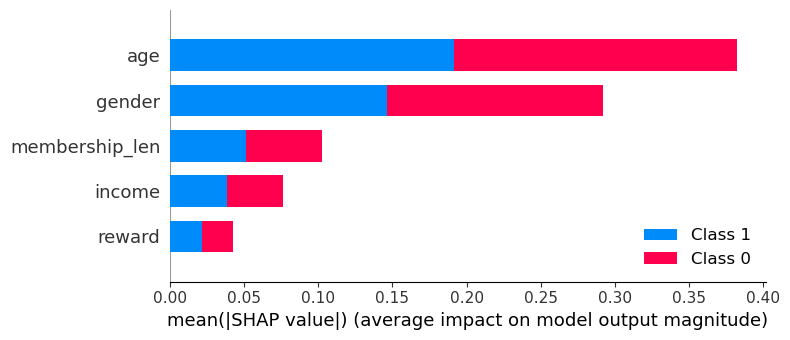

In [56]:
#explainer = shap.Explainer(model)
shap_values = explainer.shap_values(test_trueneg.reset_index()[X.columns])
shap.summary_plot(shap_values, features=test_trueneg.reset_index()[X.columns], feature_names=X.columns, plot_type="bar")

## Conclusion

In [57]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], test_trueneg.reset_index()[X.columns], feature_names=X.columns, link="logit")

Predictors as customer membership length, age, income, gender, offer difficulty and reward allow to determine if customer complete offer with AUC score 0.77 for RandomForestClassifier and 0.8 for Light Gradient Boosting. 
Unknown age and gender are one of factors that results to false negative missclassification, because costomers with uknown age and gender usually do not complete offer